In [102]:
import networkx
import statistics
import folium
import carinova_data as cd
import instance
import gomea
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import plotly_express as px
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)
import seaborn as sns


2022-01-27 12:16:53 Configured OSMnx 1.1.2
2022-01-27 12:16:53 HTTP response caching is on


### Introduction
Due to the high rate at which the Dutch society is aging, the homecare sector is faced with two major challenges:
1. An increasing demand for home care services
2. A diminishing pool of home care professionals

Home care organizations need to find ways to do more with less. Some solutions will lie in the technological domain. For instance automating the most time-consuming processes will allow for shifting more resources towards actual care-giving. One process that can be automated is planning.

This notebook describes a system for automatically establishing optimal routes for care-givers using a genetic algorithm.

### Inspect input data
The input data comes from an Excel file. Each row represents one care activity.

In [142]:
url = "example_data.xlsx"
source_data = pd.read_excel(url)
source_data.head()

,activity_id,client_nr,shift_code,shift_id,duration,tw_start,tw_end,tw_bool,activity_level_name,activity_level,latitude,longitude
0,1,2000140,AVP1-2233,0,5,NaN,NaN,0,PV 2+,2,52.269695,6.164124
1,2,705026,AVP1-2233,0,5,NaN,NaN,0,PV 3,3,52.267812,6.175048
2,3,705026,AVP1-2233,0,10,NaN,NaN,0,PV 2+,2,52.266598,6.168108
3,4,811647,AVP1-2233,0,10,NaN,NaN,0,PV 2+,2,52.269764,6.176036
4,5,819573,AVP1-2233,0,15,NaN,NaN,0,PV 2+,2,52.267690,6.166916


The activities can be placed as points in a map and each point can be colored by shift_id.

In [190]:
selection = ['shift_id','longitude', 'latitude']
location_data = source_data[selection]
n_colors = 15
colors = list(reversed(sns.color_palette("Paired", n_colors).as_hex()))
map = folium.Map(location=[location_data.latitude.mean(), location_data.longitude.mean()], zoom_start=14, control_scale=True)
for index, location_info in location_data.iterrows():
    folium.Circle(
        [location_info["latitude"],
        location_info["longitude"]],
        color=False,
        fill_color=colors[int(location_info["shift_id"])],
        fill=True,
        fill_opacity=0.7,
        popup=location_info["shift_id"]
        ).add_to(map)
map


### Read in data from Excel file

The `carinova_data.py` file contains functions for extracting and transforming the data. All the paths are hard coded in the `fetch_data()` function. The final output is a dictionary.

In [140]:
input_data = cd.fetch_data('city')
keys = input_data.keys()
items = input_data.items()
values = input_data.values()
print(keys)

dict_keys(['n', 'v', 'p', 'd', 'tw', 'Q', 'u', 'ss', 'route', 'arrival', 'arrival_nobase', 'score', 'dist', 'wt', 'ot'])


### Build Instance
The function containing the genetic algorithm needs an Instance `class`. This `class` takes in the first 8 variables of the dictionary as input.

In [146]:
n, v, p, d, tw, Q, u, ss = list(values)[:8]
ins = instance.Instance(n=n, v=v, p=p, d=d, tw=tw, Q=Q, u=u, ss=ss)
ins.__dict__.keys()

dict_keys(['n', 'v', 'd', 'p', 'tw', 'Q', 'u', 'ss', 'feasibleShiftsForClients'])

### Solve for optimal routes
The function` gomea_solve()` contains the genetic algorithm. It requires an Instance object and returns a dictionary.

In [148]:
results = gomea.gomea_solve(ins)
results.keys()


evolution cycle 0 finished in 0:00:17.971441
evolution cycle 1 finished in 0:00:18.331348
evolution cycle 2 finished in 0:00:18.002792
evolution cycle 3 finished in 0:00:18.122606
evolution cycle 4 finished in 0:00:18.067518
evolution cycle 5 finished in 0:00:18.201037
evolution cycle 6 finished in 0:00:18.021066
evolution cycle 7 finished in 0:00:17.937518
evolution cycle 8 finished in 0:00:17.920180
evolution cycle 9 finished in 0:00:17.916841
evolution cycle 10 finished in 0:00:17.746652
evolution cycle 11 finished in 0:00:17.508817
evolution cycle 12 finished in 0:00:17.280186
evolution cycle 13 finished in 0:00:17.360005
evolution cycle 14 finished in 0:00:17.178030
evolution cycle 15 finished in 0:00:17.305589


total elapsed time: 0:04:44.871627


dict_keys(['params', 'gen_count', 'time_track', 'route', 'arrival', 'score', 'distance', 'waiting_time', 'shift_overtime', 'progress', 'pop_means', 'instance'])

The `gomea_solve()` function among others returns a `route` variable which is a list of lists containing the sequences in which the caring activities should be carried out.

In [150]:
print(results['route'])


[[49, 76, 2, 37, 38, 71, 24, 25, 55, 56, 57, 66, 83, 84, 47, 48, 86], [1, 68, 19, 60, 23, 6, 63, 12, 13, 46], [67, 35, 18, 69, 78, 50, 79, 70, 39, 22, 4, 61, 74, 42, 27, 29, 30, 45], [58, 36, 77, 52, 51, 80, 41, 7, 65, 28, 44, 82, 32, 34, 14, 15, 16], [20, 21, 3, 54, 40, 26, 75, 43, 31, 33, 85, 17, 87], [81], [59, 53, 72, 73, 5, 62, 64, 8, 9, 10, 11]]


### Visualize routes
The quality of the calculated routes can be assessed by plotting them on a map. First the routes are recombined with source data and put into a data frame.

In [8]:
routes_array = results['route']
cols = ['route_id', 'activity_id', 'shift_id', 'longitude', 'latitude']
routes_list = []
for rt, route in enumerate(routes_array):
    for act in route:
        activity = source_data[source_data['activity_id'] == act]
        activity_id, shift_id, longitude, latitude = activity[cols[1:]].values[0] # exclude 'route_id' from cols
        temp_arr = [rt, activity_id, shift_id, longitude, latitude]
        routes_list.append(temp_arr)
routes_df = pd.DataFrame(routes_list, columns=cols)
routes_df

,route_id,activity_id,shift_id,longitude,latitude
0,0,77.0,6.0,6.164641,52.269232
1,0,68.0,5.0,6.164916,52.269976
2,0,1.0,0.0,6.164124,52.269695
3,0,78.0,6.0,6.170035,52.268266
4,0,37.0,2.0,6.174667,52.269753
...,...,...,...,...,...
82,5,29.0,1.0,6.170264,52.271932
83,5,45.0,2.0,6.170424,52.271781
84,5,14.0,0.0,6.173817,52.269402
85,6,81.0,6.0,6.146972,52.279305


With this data a map with all activity locations can be generated. In this case the color represents the route_id.

In [191]:
map = folium.Map(location=[routes_df.latitude.mean(
), routes_df.longitude.mean()], zoom_start=14, control_scale=True)
for index, location_info in routes_df.iterrows():
    folium.Circle(
        [location_info["latitude"],
        location_info["longitude"]],
        color=False,
        fill_color=colors[int(location_info["route_id"])],
        fill=True,
        fill_opacity=0.7,
        popup=location_info["route_id"]
    ).add_to(map)
map


In order to plot the actual routes (nodes and edges) the map needs to be converted to graph. In this case this has already been done and the graph can be loaded from a saved file.

2022-01-27 09:49:48 Converting node, edge, and graph-level attribute data types
2022-01-27 09:49:49 Loaded graph with 20870 nodes and 39886 edges from "deventer_graph.graphml"
2022-01-27 09:49:49 Begin plotting the graph...
2022-01-27 09:49:52 Created edges GeoDataFrame from graph
2022-01-27 09:49:54 Created nodes GeoDataFrame from graph


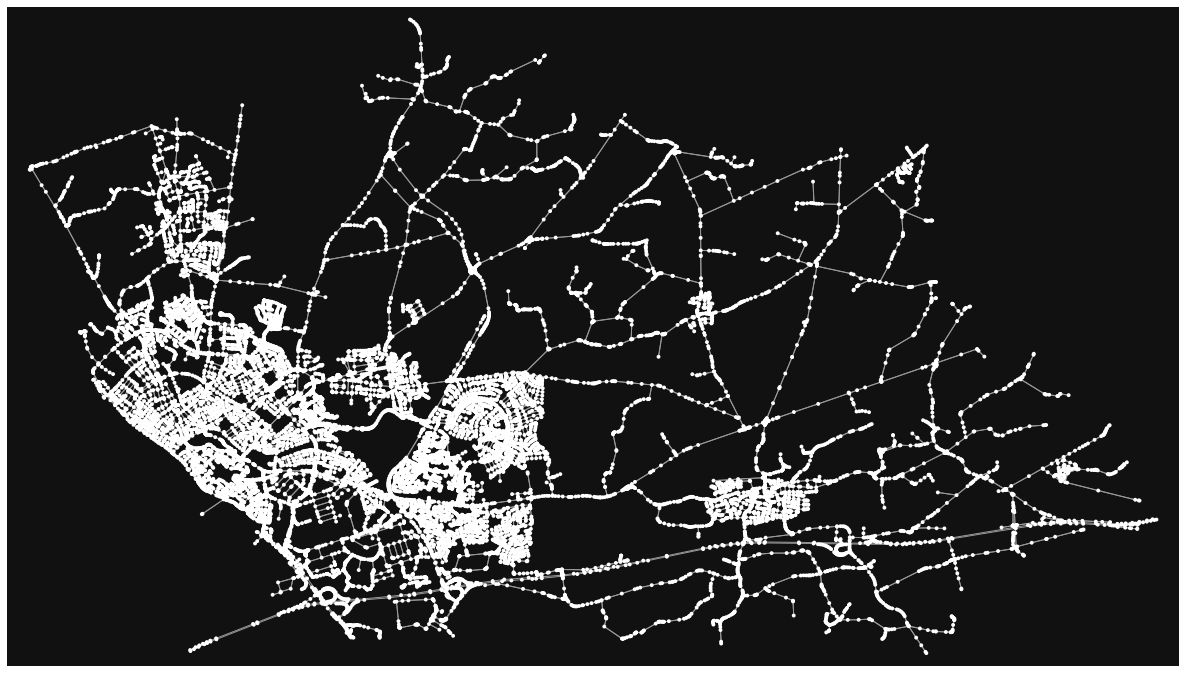

2022-01-27 09:49:56 Finished plotting the graph


(<Figure size 1512x1512 with 1 Axes>, <AxesSubplot:>)

In [22]:
deventer_graph = ox.load_graphml("deventer_graph.graphml")
ox.plot_graph(deventer_graph, figsize=(21, 21))

The nodes in the graph have unique identifiers. The activity locations need to be associated with the nodes on the graph. Then each journey from one activity to the next has to be described as a path on the graph. The following function takes in a route_id, a data frame with route_ids and coordinates and returns a list of list of nodes. Each list of nodes represents a stage in the total route.

In [179]:
def calc_route(route_id: int, path_coordinates, graph):
    route_id = route_id
    # Get arrays of longitudes and latitudes for path for a given rout_id
    lon_array = path_coordinates[path_coordinates.route_id == route_id].longitude
    lat_array = path_coordinates[path_coordinates.route_id == route_id].latitude
    
    # Calculates nearest nodes for all path coordinates from arrays
    node_list = ox.distance.nearest_nodes(
        G=deventer_graph,
        X=lon_array,
        Y=lat_array
    )

    # for each pair of subsequent nodes calculate shortest path and append array of path nodes to route array
    route = []
    for i in range(len(node_list) - 1):
        start = node_list[i]
        end = node_list[i + 1]
        path_nodes = networkx.shortest_path( graph, start, end)
        route.append(path_nodes)
        i += 1
        
    # return route as list
    return(route)
    
# Test
route_id = 2
route_list = calc_route(route_id, routes_df, deventer_graph)
print(route_list)


2022-01-27 18:07:32 Created nodes GeoDataFrame from graph
[[4578945773, 45959730, 3747461817, 1385141011, 3747461815, 3747461814, 3747461813, 3747461812, 3747461810, 3747461809, 748353638, 45956988, 45956612, 3623011940, 3623011939, 3623011938, 45955890, 45954740, 45952458, 3747104717, 45951486, 45951006, 3747104703, 3747104698, 45949000, 45949448, 3747104697, 45950545, 45951008, 45953740, 45953927, 45953943], [45953943, 45953927, 45953740, 45951008, 45950545, 3747104697, 45949448, 45949000, 3747104698, 3747104703, 45951006, 45951486, 3747104717, 45952458, 45954740, 45955890, 3623011938, 3623011939, 3623011940, 45956612], [45956612, 45956988, 7077650413, 748344549, 7021234924, 45960224], [45960224, 7021234924, 748344549, 7077650413, 45956988, 748353638, 45957172, 45957383, 6793653053, 738033964, 45957457, 3747461815, 1385141011, 3747461817, 45959730, 4578945773], [4578945773, 45964871], [45964871, 4578945773, 45959730, 3747461817, 1385141011, 3747461815, 3747461814, 3747461813, 3747461

The function `ox.plot_graph_routes()` can generate a route with different stages.

2022-01-27 18:08:03 Created bbox 500 m from (52.268389459973534, 6.174779617928298): 52.272886061651,52.26389285829607,6.182127444861196,6.1674317909953995
2022-01-27 18:08:03 Begin plotting the graph...
2022-01-27 18:08:06 Created edges GeoDataFrame from graph
2022-01-27 18:08:09 Created nodes GeoDataFrame from graph
2022-01-27 18:08:09 Finished plotting the graph


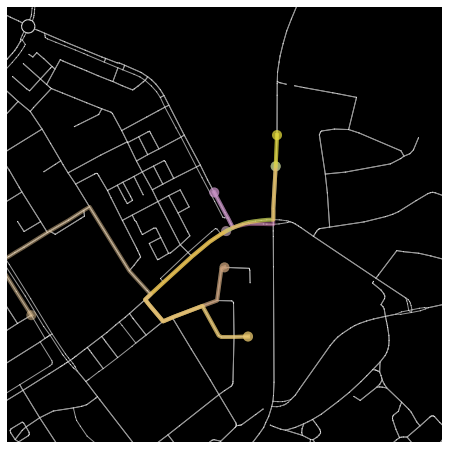

In [182]:
bbox = ox.utils_geo.bbox_from_point((mid[1], mid[0]), dist=500)
n_colors = 20
# colors = list(sns.light_palette("seagreen", n_colors).as_hex())
colors = sns.color_palette("Set2", n_colors).as_hex()
rc = colors[:len(route_list)]
fig, ax = ox.plot_graph_routes(
    deventer_graph, route_list, bbox=bbox, route_colors=rc, route_linewidth=3, node_size=1, bgcolor='k')


The graph does not contain any map details, eg. street names. With a minor tweak (for-loop) the route can be plotted on a map.

In [193]:
route_map=None
for i, stage in enumerate(route_list):
    route_map = ox.folium.plot_route_folium(
        G=deventer_graph, route=stage, route_map=route_map, color='red', weight=2, zoom=3)
route_map


2022-01-27 20:17:44 Created edges GeoDataFrame from graph


In [189]:
route_map = None
route_ids = pd.unique(routes_df.route_id.values)
# route_ids = [0, 1]
print(route_ids)
# Generate route_list
for id in route_ids:
    print(id)
    route_list = calc_route(id, routes_df, deventer_graph)
    print(route_list)
    for stage in route_list:
        route_map = ox.folium.plot_route_folium(
            G=deventer_graph, route=stage, route_map=route_map, color=colors[id], weight=7, zoom=3, opacity=0.3)
        
route_map




[0 1 2 3 4 5 6]
0
2022-01-27 18:11:35 Created nodes GeoDataFrame from graph
[[45962658, 45961047, 4578945807, 45958227, 45958356, 2459446071, 45962659, 45964126], [45964126, 45964181, 4578945810, 5814396443, 5814396444, 45964637, 738033959, 45965469, 4338841801, 45965815, 417851802, 4338841803, 45966125, 45965709, 2461525760, 4578131370, 4578131379, 4578131378, 4578131358], [4578131358, 4578131378, 4578131379, 4578131370, 2461525760, 45965709, 4338841800, 45965495, 45965282, 45964671, 738033940, 3623011954, 45964291, 4543546875, 4578945813, 3623011952, 3623011951, 45963805, 45962658, 45961047, 4578945807, 45958227, 3699008363, 45954316, 45954378, 738033952, 3699008366, 45955519, 45956632, 8337698474, 8337698473, 8337698472], [8337698472, 8337698471, 8337698470, 45958875, 45961023, 45962059, 45963465, 45964437, 45965471, 7514070088, 7514070087, 748344536, 45967494, 45965002, 45962550], [45962550, 45965002], [45965002, 45967494, 748344536, 7514070087, 7514070088, 45965471, 45966940, 4317